In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers,models

In [28]:
IMAGE_SIZE=256
BATCH_SIZE=32
EPOCH=25

In [29]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "plant",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [30]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

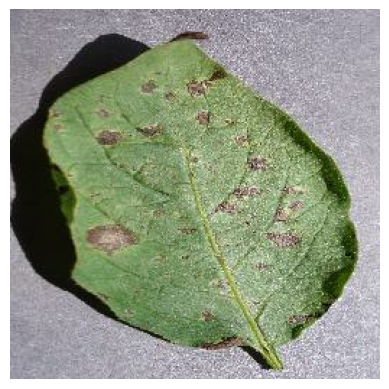

In [31]:
for image_batch,label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.axis("off")

In [32]:
train_size=0.8
train_ds=dataset.take(54)
print(len(train_ds))

54


In [33]:
train_ds

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [34]:
test_ds=dataset.skip(54)


In [35]:
val_size=0.1
val_ds=test_ds.take(6)

In [36]:
test_ds=test_ds.skip(6)

In [37]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [38]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [39]:
train_ds

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [40]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [41]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

In [42]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [43]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [44]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3)
n_classes=3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape)


In [45]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [46]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [47]:
history=model.fit(train_ds,epochs=EPOCH,batch_size=BATCH_SIZE,verbose=1,validation_data=val_ds)

Epoch 1/25
54/54 [==============================] - 15s 179ms/step - loss: 0.9064 - accuracy: 0.4983 - val_loss: 0.8319 - val_accuracy: 0.6875
Epoch 2/25
54/54 [==============================] - 7s 132ms/step - loss: 0.6399 - accuracy: 0.7153 - val_loss: 0.6645 - val_accuracy: 0.7188
Epoch 3/25
54/54 [==============================] - 7s 128ms/step - loss: 0.3568 - accuracy: 0.8530 - val_loss: 0.6786 - val_accuracy: 0.7552
Epoch 4/25
54/54 [==============================] - 7s 128ms/step - loss: 0.3131 - accuracy: 0.8762 - val_loss: 0.2445 - val_accuracy: 0.9062
Epoch 5/25
54/54 [==============================] - 7s 127ms/step - loss: 0.2290 - accuracy: 0.9034 - val_loss: 0.2762 - val_accuracy: 0.8906
Epoch 6/25
54/54 [==============================] - 7s 127ms/step - loss: 0.2087 - accuracy: 0.9120 - val_loss: 0.1383 - val_accuracy: 0.9531
Epoch 7/25
54/54 [==============================] - 7s 128ms/step - loss: 0.1516 - accuracy: 0.9387 - val_loss: 0.1502 - val_accuracy: 0.9323
Epoch

In [48]:
model.save('my_model.keras') 

In [49]:
from tensorflow.keras.models import load_model

# Load the model
new_model = tf.keras.models.load_model('my_model.keras')


In [50]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 64)       

In [51]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 2s 56ms/step - loss: 0.0690 - accuracy: 0.9805


In [52]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]

loss=history.history["loss"]
val_loss=history.history["val_loss"]

Text(0.5, 1.0, 'Training and validation loss')

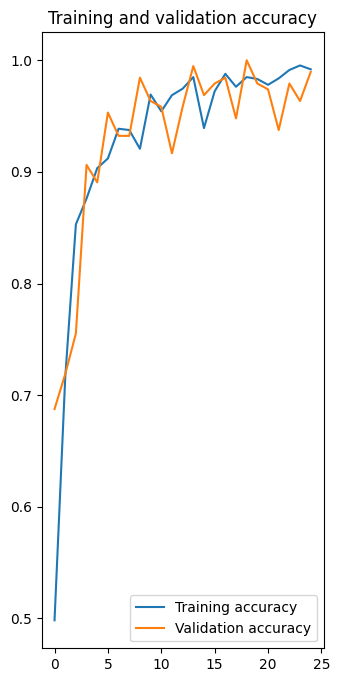

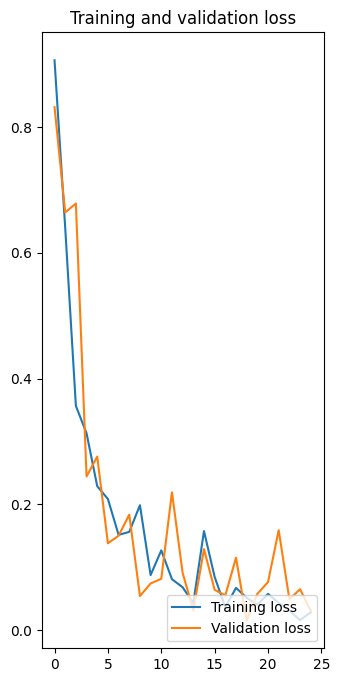

In [53]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCH),acc,label="Training accuracy")
plt.plot(range(EPOCH),val_acc,label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Training and validation accuracy")

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCH),loss,label="Training loss")
plt.plot(range(EPOCH),val_loss,label="Validation loss")
plt.legend(loc="lower right")
plt.title("Training and validation loss")

In [54]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


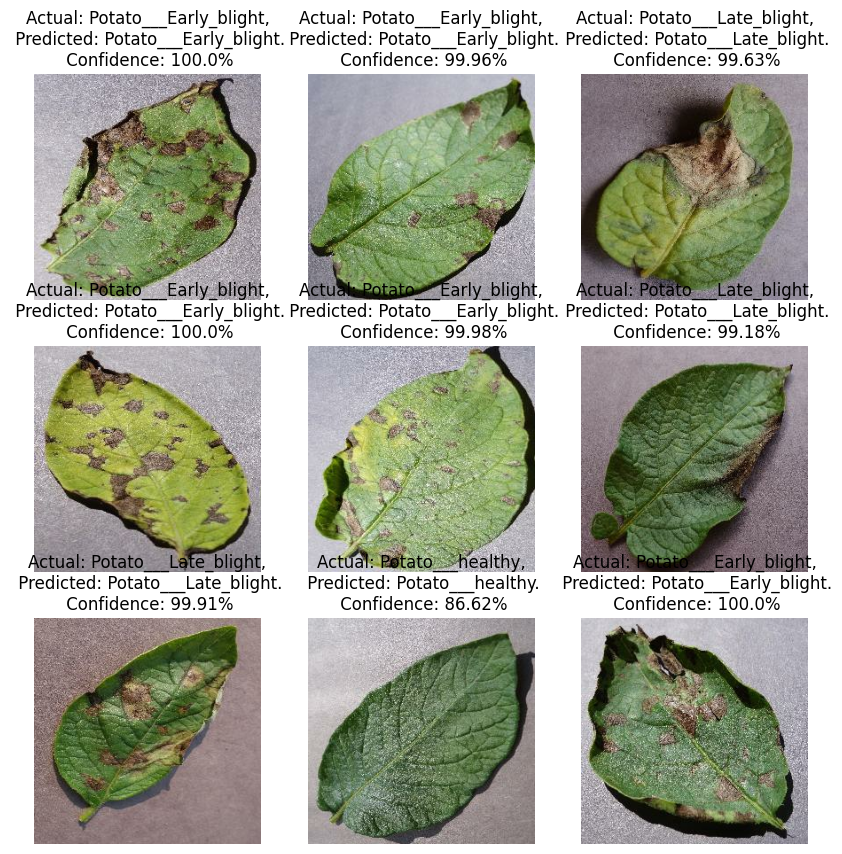

In [55]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [56]:
import os
model_version=max([int(i) for i in os.listdir("./models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
